In [1]:
# Basics
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

# Trying out a bunch of things. 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB

#Maths 
from numpy import absolute
from numpy import mean
from numpy import std

#Visalization
from matplotlib import pyplot as plt
import seaborn as sns

# Clean up options
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.precision", 2)

In [2]:
# Read All IPL Data
deliveres = pd.read_csv("C:/Users/utkar/OneDrive/Desktop/Analytics/Data/IPL Ball-by-Ball 2008-2020.csv")
matches = pd.read_csv("C:/Users/utkar/OneDrive/Desktop/Analytics/Data/IPL Matches 2008-2020.csv")
# Populated with data from cricinfo for bowlers who have bowled in atleasst 10 matches
# bowler_data = pd.read_csv("C:/Users/utkar/OneDrive/Desktop/Analytics/Data/Bowlers.csv")

del_df = deliveres.copy()
#del_df = del_df[del_df.id >= 980901]
match_df = matches.copy()
#match_df = match_df[match_df.id >= 980901]

In [3]:
selected_batsman = 'V Kohli'

In [4]:
batsman_df = del_df[del_df.batsman == selected_batsman]

In [5]:
comb = pd.merge(batsman_df, match_df, on = 'id', how='left')

In [6]:
comb = comb.drop(["non_striker", "extra_runs", "total_runs" , 'batting_team', 'non_boundary' , 'dismissal_kind' , 'fielder' , 'extras_type' , 'city' , 'date' , 'player_of_match' , 'neutral_venue' , 'team1' , 'team2' , 'toss_winner' , 'toss_decision' , 'winner' , 'result' , 'result_margin' , 'eliminator' , 'method' , 'umpire1' , 'umpire2'], axis=1)

In [7]:
tmpRuns = pd.DataFrame(comb.groupby('id').batsman_runs.sum()).rename(columns = {'batsman_runs' : 'totalRuns'}).reset_index()
tmpBalls = pd.DataFrame(comb.groupby('id').batsman_runs.count()).rename(columns = {'batsman_runs' : 'totalBalls'}).reset_index()

In [8]:
comb = pd.merge(comb, tmpRuns, on = 'id' , how = 'left').reset_index(drop=True)
comb = pd.merge(comb, tmpBalls, on = 'id' , how = 'left').reset_index(drop=True)

In [9]:
OversLeftAtEntry = pd.DataFrame(20 - comb.groupby('id').over.min()).rename(columns = {'over' : 'oversLeft'}).reset_index()

In [10]:
comb = comb.drop(['over' , 'ball' , 'batsman_runs', 'player_dismissed', 'bowler' , 'is_wicket'] , axis=1)

In [11]:
# comb = comb.drop(['BowlingStyle'], axis=1)
# comb = pd.get_dummies(comb, columns = ['bowling_team'], prefix='against_').reset_index(drop=True)
# comb = pd.get_dummies(comb, columns = ['venue'], prefix='venue_').reset_index(drop=True)
# comb = pd.get_dummies(comb, columns = ['inning'], prefix = 'inning_').reset_index(drop=True)
comb = comb.drop_duplicates().reset_index(drop=True)

In [12]:
comb = pd.merge(comb, OversLeftAtEntry, on = 'id', how = 'left')

In [13]:
Avg = pd.DataFrame(comb.totalRuns.rolling(5, min_periods=1).mean())
comb['RollingAvg'] =  Avg

In [14]:
teams = comb.bowling_team.unique()
team_dict = {}
for index,value in enumerate(teams):
    team_dict[value] = 0
# print(team_dict)

venues = comb.venue.unique()
venue_dict = {}
for index,value in enumerate(venues):
    venue_dict[value] = 0
# print(venue_dict)

In [15]:
def getCurrentMatchNumberByBowlingTeam(bowling_team): 
    team_dict[bowling_team]+=1
    return team_dict[bowling_team]

def getCurrentMatchNumberByVenue(venue): 
    venue_dict[venue]+=1
    return venue_dict[venue]

In [16]:
comb['matchesAgainstOpposition'] = comb.apply(lambda x: getCurrentMatchNumberByBowlingTeam(x['bowling_team']), axis=1)
comb['matchesAtVenue'] = comb.apply(lambda x: getCurrentMatchNumberByVenue(x['venue']), axis=1)

In [17]:
comb['runsAgainstOppostion'] = comb.groupby('bowling_team').totalRuns.cumsum()
comb['runsAtVenue'] = comb.groupby('venue').totalRuns.cumsum()

In [18]:
# Why does this come in .... 
# debug !!! 
comb = comb.loc[:, ~comb.columns.str.contains('^Unnamed')]

In [19]:
comb['AvgAgainstOpposition'] = comb.apply(lambda x: x['runsAgainstOppostion'] / x['matchesAgainstOpposition'] , axis=1)
comb['AvgAtVenue'] = comb.apply(lambda x: x['runsAtVenue'] / x['matchesAtVenue'] , axis=1)

In [20]:
comb.head(10)

,id,inning,batsman,bowling_team,venue,totalRuns,totalBalls,oversLeft,RollingAvg,matchesAgainstOpposition,matchesAtVenue,runsAgainstOppostion,runsAtVenue,AvgAgainstOpposition,AvgAtVenue
0,335982,2,V Kohli,Kolkata Knight Riders,M Chinnaswamy Stadium,1,5,19,1.00,1,1,1,1,1.0,1.00
1,335985,2,V Kohli,Mumbai Indians,Wankhede Stadium,23,15,10,12.00,1,1,23,23,23.0,23.00
2,335992,1,V Kohli,Rajasthan Royals,M Chinnaswamy Stadium,13,16,14,12.33,1,2,13,14,13.0,7.00
3,335996,2,V Kohli,Chennai Super Kings,M Chinnaswamy Stadium,12,7,5,12.25,1,3,12,26,12.0,8.67
4,335998,2,V Kohli,Delhi Daredevils,Feroz Shah Kotla,1,1,1,10.00,1,1,1,1,1.0,1.00
5,336002,2,V Kohli,Deccan Chargers,"Rajiv Gandhi International Stadium, Uppal",9,5,5,11.60,1,1,9,9,9.0,9.00
6,336006,1,V Kohli,Kings XI Punjab,M Chinnaswamy Stadium,34,39,19,13.80,1,4,34,60,34.0,15.00
7,336012,1,V Kohli,Mumbai Indians,M Chinnaswamy Stadium,0,1,8,11.20,2,5,23,60,11.5,12.00
8,336016,1,V Kohli,Kings XI Punjab,"Punjab Cricket Association Stadium, Mohali",21,23,20,13.00,2,1,55,21,27.5,21.00
9,336023,2,V Kohli,Rajasthan Royals,Sawai Mansingh Stadium,3,8,20,13.40,2,1,16,3,8.0,3.00


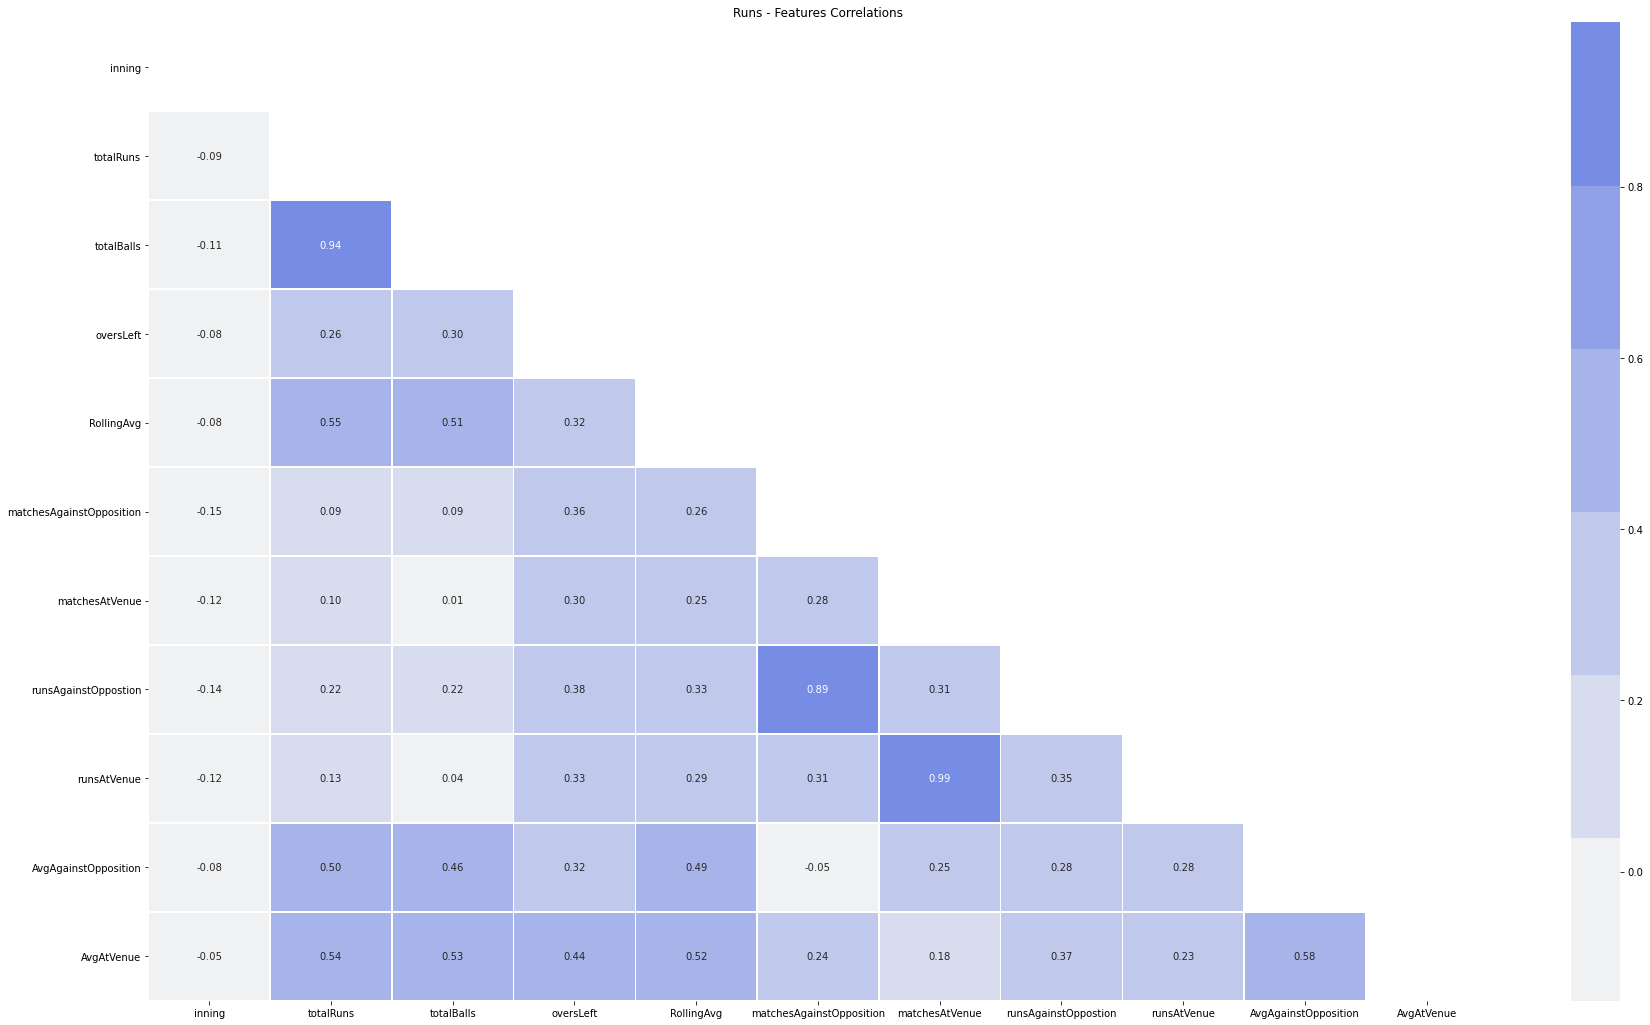

In [21]:
# Plot a correlation Heat Map 

fig, ax = plt.subplots(figsize=(30, 18))
corr = comb.drop(labels = ['id'] , axis=1).corr()


myMask = np.zeros_like(corr)
myMask[np.triu_indices_from(myMask)] = True

colormap = sns.light_palette((260, 75, 60), input="husl")

sns.heatmap(corr, cmap=colormap, linewidths=.5, annot=True, fmt=".2f", mask=myMask)
plt.title('Runs - Features Correlations')

plt.show()

### Predicting Batsman's score based on above metrics

In [22]:
# Choosing Features 
x = comb.drop(labels = ['id' , 'inning' , 'batsman' , 'totalRuns', 'bowling_team' , 'venue'], axis=1)

# We need prediction for Total Runs, always. So this is fixed 
y = comb['totalRuns'].values

# Split the data into test/train - 70/30 
x_train , x_test , y_train , y_test = train_test_split(x , y, test_size = 0.3 , random_state = 42)

In [23]:
# Linear Regressor 
linear_regressor = LinearRegression()
linear_regressor.fit(x_train, y_train)

print(linear_regressor.score(x_train, y_train))
y_pred = linear_regressor.predict(x_test)
print(linear_regressor.score(x_test, y_test))
mean_absolute_error(y_test, y_pred)

0.9074672354721077
0.9012922465451112


6.467916244659498

In [24]:
# Poisson Regressor 
# debug this - not looking correct 
poisson_regressor = PoissonRegressor()
poisson_regressor.fit(x_train, y_train)

print(poisson_regressor.score(x_train, y_train))
y_pred = poisson_regressor.predict(x_test)
print(poisson_regressor.score(x_test, y_test))
mean_absolute_error(y_test, y_pred)

0.0
-0.0007345493044239593


21.04296875

In [25]:
# Random Forest Regressor
rdf_regressor = RandomForestRegressor(n_estimators=100,max_features=None)
rdf_regressor.fit(x_train,y_train)

print(rdf_regressor.score(x_train,y_train))
y_pred = rdf_regressor.predict(x_test)
print(rdf_regressor.score(x_test,y_test))
mean_absolute_error(y_test, y_pred)

0.9867857928581093
0.891123052092696


6.5525

In [26]:
# GaussianNB
nb_model=GaussianNB()
nb_model.fit(x_train,y_train)

print(nb_model.score(x_train,y_train))
y_pred=nb_model.predict(x_test)
print(nb_model.score(x_test,y_test))
mean_absolute_error(y_test, y_pred)

0.7734375
0.03571428571428571


11.232142857142858

In [27]:
# Decision Tree
dt_regressor = DecisionTreeRegressor(criterion='mse', splitter='best',
                             max_depth=None, min_samples_split=2,
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0,
                             max_features=None, random_state=None,
                             max_leaf_nodes=None, min_impurity_decrease=0.0, 
                             min_impurity_split=None, 
                             ccp_alpha=0.0)


dt_regressor.fit(x_train,y_train)

print(dt_regressor.score(x_train,y_train))
y_pred=dt_regressor.predict(x_test)
print(dt_regressor.score(x_test,y_test))
mean_absolute_error(y_test, y_pred)

1.0
0.7776544609011685


9.035714285714286

In [28]:
x_test.head(10)

,totalBalls,oversLeft,RollingAvg,matchesAgainstOpposition,matchesAtVenue,runsAgainstOppostion,runsAtVenue,AvgAgainstOpposition,AvgAtVenue
19,22,15,14.8,4,1,34,15,8.50,15.00
42,24,8,34.2,4,2,52,32,13.00,16.00
156,33,17,23.2,23,66,617,2158,26.83,32.70
111,19,20,45.0,6,6,291,279,48.50,46.50
148,26,12,48.0,22,64,571,2100,25.95,32.81
15,3,4,20.8,3,1,57,2,19.00,2.00
24,8,9,21.6,5,2,123,31,24.60,15.50
68,41,18,32.6,10,3,306,122,30.60,40.67
117,34,20,42.2,17,7,358,280,21.06,40.00
98,53,16,43.0,16,37,595,988,37.19,26.70


In [29]:
def predict_score(df, totalBalls, oversLeft, RollingAvg, matchesAgainstOpposition, matchesAtVenue, runsAgainstOpposition, runsAtVenue, AvgAgainstOpposition, AvgAtVenue): 
    
    test_input = [[totalBalls, oversLeft, RollingAvg, matchesAgainstOpposition, matchesAtVenue, runsAgainstOpposition, runsAtVenue, AvgAgainstOpposition, AvgAtVenue]]
    
    
    print ("Linear Regression Prediction - " + str(linear_regressor.predict(test_input)))
    print ("Poisson Regression Prediction - " + str(poisson_regressor.predict(test_input)))
    print ("Random Forest Regression Prediction - " + str(rdf_regressor.predict(test_input)))
    print ("Gaussian Prediction - " + str(nb_model.predict(test_input)))
    print ("Decision Tree Regression Prediction - " + str(dt_regressor.predict(test_input)))
    
    real = df[(df.totalBalls == totalBalls) & (df.oversLeft == oversLeft) & (df.RollingAvg == RollingAvg)].totalRuns.sum()
    print("Real output - " , str(real))

In [30]:
# Get a Prediction from all models for same data for comparison
predict_score(comb, 51, 20, 41.6, 4, 2, 273, 164, 68.25, 82.00)

Linear Regression Prediction - [68.53951325]
Poisson Regression Prediction - [31.734375]
Random Forest Regression Prediction - [78.81]
Gaussian Prediction - [67]
Decision Tree Regression Prediction - [93.]
Real output -  64
